## Imports

In [1]:
import pandas as pd
import pandana as pdna
from pandana.loaders import osm
import numpy as np
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
import osmnx as ox

print(f"OSMnx version: {ox.__version__}")

ox.settings.use_cache = True

ox.settings.log_console = True


warnings.filterwarnings('ignore')

print(f"Pandana version: {pdna.__version__}")

OSMnx version: 2.0.7
Pandana version: 0.7


##Load graph

In [2]:
# Format: (lng_min, lat_min, lng_max, lat_max)
#bbox = (12.08625, 55.73939, 12.14461, 55.78072)

# Load network using pandana's OSM loader
# Note: lat/lng order is different for the function
#network = osm.pdna_network_from_bbox(
 #   lat_min=bbox[1],  # 55.73939
  #  lng_min=bbox[0],  # 12.08625
   # lat_max=bbox[3],  # 55.78072
    #lng_max=bbox[2],  # 12.14461
    #network_type='walk'  # Options: 'walk', 'drive', 'bike', 'drive_service', 'all'
#)

#print(f"Network loaded with {len(network.nodes_df)} nodes and {len(network.edges_df)} edges")



In [3]:
bbox = 12.4763, 55.5504, 12.6878, 55.7016

G = ox.graph.graph_from_bbox(bbox, simplify = True, network_type="walk") 

Project the graph

In [4]:
G = ox.project_graph(G)

Convert osmnx -> pandana

In [5]:
n, e = ox.graph_to_gdfs(G)

e = e.reset_index()

network = pdna.Network(n.geometry.x, n.geometry.y, e["u"], e["v"], e[["length"]])

## Adding features

In [10]:
places = [
    "Copenhagen Municipality, Denmark",
    "Frederiksberg Municipality, Denmark",
]

pois = ox.features_from_place(
    places,
    tags={"amenity": "library"}
)

pois = pois.to_crs(n.crs)

# Force everything to points
pois = pois.copy()
pois["geometry"] = pois.geometry.centroid


#distance we look within (m)
dist = 1000

# Register POIs with Pandana
network.set_pois(
    category="library",
    maxdist=2000,
    maxitems=100,
    x_col=pois.geometry.x,
    y_col=pois.geometry.y
)


# get distances to nearest 100 cafes
nearest_libraries = network.nearest_pois(
    distance=2000,
    category="library",
    num_pois=100,
)



n["nearest_libraries"] = (nearest_libraries <= dist).sum(axis=1)

Draw graph with OSMnx and overlay with pandana

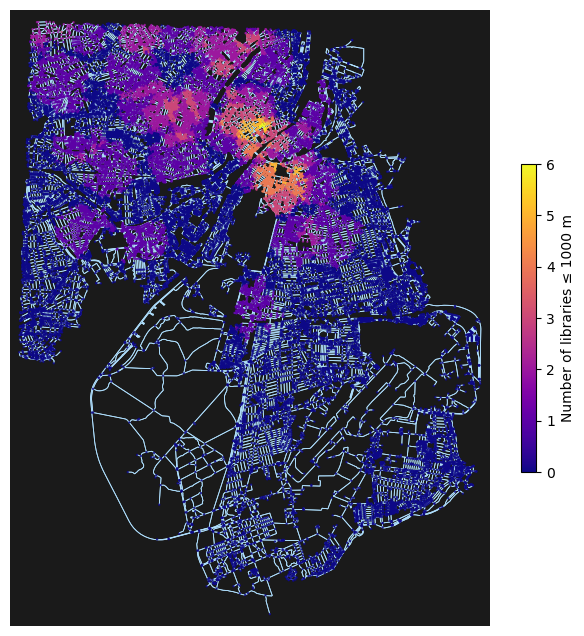

In [11]:
fig, ax = ox.plot.plot_graph(
    G,
    node_size=0,
    edge_color="#afdffe",
    edge_linewidth=0.6,
    bgcolor="#1a1a1a",
    show=False,
    close=False
)
"""
n.plot(
    ax=ax,
    column="nearest_libraries",
    cmap="plasma",
    markersize=0.5,
    alpha=0.8,
    legend=True,
) """

vmin = n["nearest_libraries"].min()
vmax = n["nearest_libraries"].max()

n.plot(
    ax=ax,
    column="nearest_libraries",
    cmap="plasma",
    markersize=0.5,
    alpha=0.8,
    legend=True,
    facecolor="white",
    legend_kwds={
        "shrink": 0.5,
        "label": f"Number of libraries ≤ {dist} m",
        "orientation": "vertical"
    },
    vmin=0,
    vmax=vmax
)


"""
# Plot distance to nearest restaurant using Pandana's plot method
network.plot(
    nearest_restaurants[1],  # Distance to 1st nearest restaurant
    bbox=bbox,
    fig_kwargs={'figsize': (15, 15), 'facecolor': '#1a1a1a'},
    plot_kwargs={
        'cmap': 'plasma',         # Works well on dark backgrounds
        's': 15,
        'edgecolor': 'none',
        'alpha': 0.8
    },
)"""
plt.show()


